# Over-fitting and model selection

## References

* Bishop Christopher M., 1995, Neural networks for pattern recognition. Figure 1.4, page 7

In [1]:
import openturns as ot
ot.RandomGenerator.SetSeed(0)

In [2]:
g = ot.SymbolicFunction(['x'], ['sin(2*pi_*x)'])

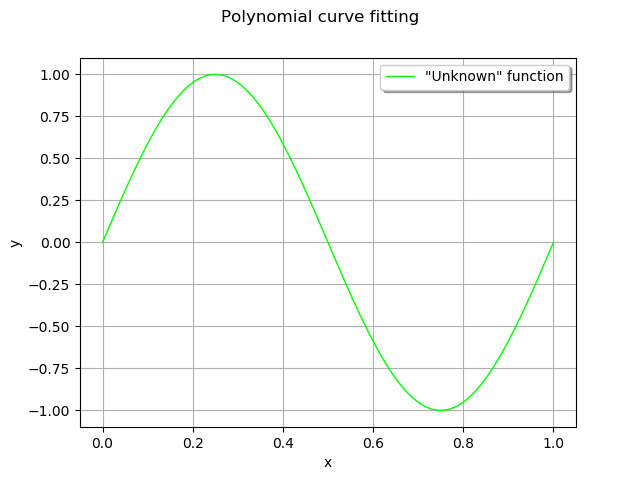

In [3]:
graph = ot.Graph("Polynomial curve fitting","x","y",True,"topright")
# The "unknown" function
curve = g.draw(0,1)
curve.setColors(["green"])
curve.setLegends(["\"Unknown\" function"])
graph.add(curve)
graph

In [4]:
npoints = 10

In [5]:
noise = ot.Normal(0,0.1)
noiseSample = noise.getSample(npoints)
noiseSample

class=Sample name=Normal implementation=class=SampleImplementation name=Normal size=10 dimension=1 description=[X0] data=[[0.0608202],[-0.126617],[-0.0438266],[0.120548],[-0.218139],[0.0350042],[-0.0355007],[0.143725],[0.0810668],[0.0793156]]

In [6]:
def linearSample(xmin,xmax,npoints):
    '''Returns a sample created from a regular grid 
    from xmin to xmax with npoints points.'''
    step = (xmax-xmin)/(npoints-1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

In [7]:
x_train = linearSample(0,1,npoints)

In [8]:
y_train = g(x_train) + noiseSample

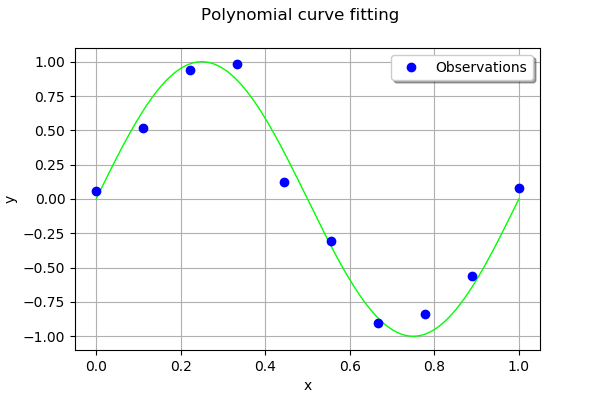

In [9]:
graph = ot.Graph("Polynomial curve fitting","x","y",True,"topright")
# The "unknown" function
curve = g.draw(0,1)
curve.setColors(["green"])
graph.add(curve)
# Training set
cloud = ot.Cloud(x_train,y_train)
cloud.setPointStyle("circle")
cloud.setLegend("Observations")
graph.add(cloud)
graph

In [10]:
total_degree = 4
polynomialCollection = ["x^%d" % (degree) for degree in range(1,total_degree+1)]
polynomialCollection

['x^1', 'x^2', 'x^3', 'x^4']

In [11]:
basis = ot.SymbolicFunction(['x'], polynomialCollection)
basis

class=SymbolicFunction name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x,y0,y1,y2,y3] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x] outputVariablesNames=[y0,y1,y2,y3] formulas=[x^1,x^2,x^3,x^4] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x] outputVariablesNames=[y0,y1,y2,y3] formulas=[x^1,x^2,x^3,x^4] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x] outputVariablesNames=[y0,y1,y2,y3] formulas=[x^1,x^2,x^3,x^4]

In [12]:
designMatrix = basis(x_train)
designMatrix

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=4 description=[y0,y1,y2,y3] data=[[0,0,0,0],[0.111111,0.0123457,0.00137174,0.000152416],[0.222222,0.0493827,0.0109739,0.00243865],[0.333333,0.111111,0.037037,0.0123457],[0.444444,0.197531,0.0877915,0.0390184],[0.555556,0.308642,0.171468,0.0952599],[0.666667,0.444444,0.296296,0.197531],[0.777778,0.604938,0.470508,0.36595],[0.888889,0.790123,0.702332,0.624295],[1,1,1,1]]

In [13]:
myLeastSquares = ot.LinearLeastSquares(designMatrix, y_train)
myLeastSquares.run()

In [14]:
responseSurface = myLeastSquares.getResponseSurface()

In [15]:
x_test = linearSample(0,1,50)

In [16]:
y_test = responseSurface(basis(x_test))

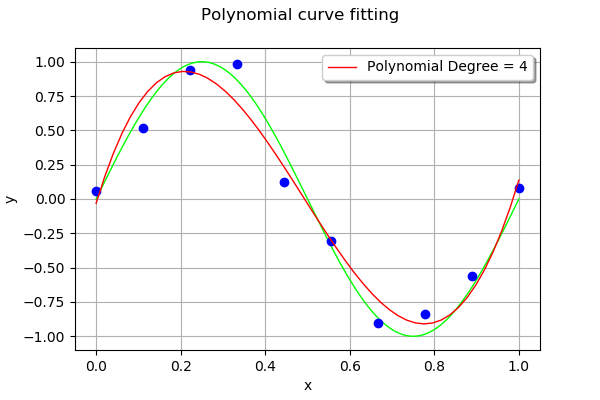

In [17]:
graph = ot.Graph("Polynomial curve fitting","x","y",True,"topright")
# The "unknown" function
curve = g.draw(0,1)
curve.setColors(["green"])
graph.add(curve)
# Training set
cloud = ot.Cloud(x_train,y_train)
cloud.setPointStyle("circle")
graph.add(cloud)
# Predictions
curve = ot.Curve(x_test,y_test)
curve.setLegend("Polynomial Degree = %d"% (total_degree))
curve.setColor("red")
graph.add(curve)
graph

In [20]:
def myPolynomialCurveFittingGraph(total_degree):
    '''Returns the graphics for a polynomial curve fitting 
    with given total degree'''
    polynomialCollection = ["x^%d" % (degree) for degree in range(1,total_degree+1)]
    basis = ot.SymbolicFunction(['x'], polynomialCollection)
    designMatrix = basis(x_train)
    myLeastSquares = ot.LinearLeastSquares(designMatrix, y_train)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getResponseSurface()
    x_test = linearSample(0,1,100)
    y_test = responseSurface(basis(x_test))
    # Graphics
    graph = ot.Graph("Polynomial curve fitting","x","y",True,"topright")
    # The "unknown" function
    curve = g.draw(0,1)
    curve.setColors(["green"])
    graph.add(curve)
    # Training set
    cloud = ot.Cloud(x_train,y_train)
    cloud.setPointStyle("circle")
    graph.add(cloud)
    # Predictions
    curve = ot.Curve(x_test,y_test)
    curve.setLegend("Polynomial Degree = %d"% (total_degree))
    curve.setColor("red")
    graph.add(curve)
    return graph

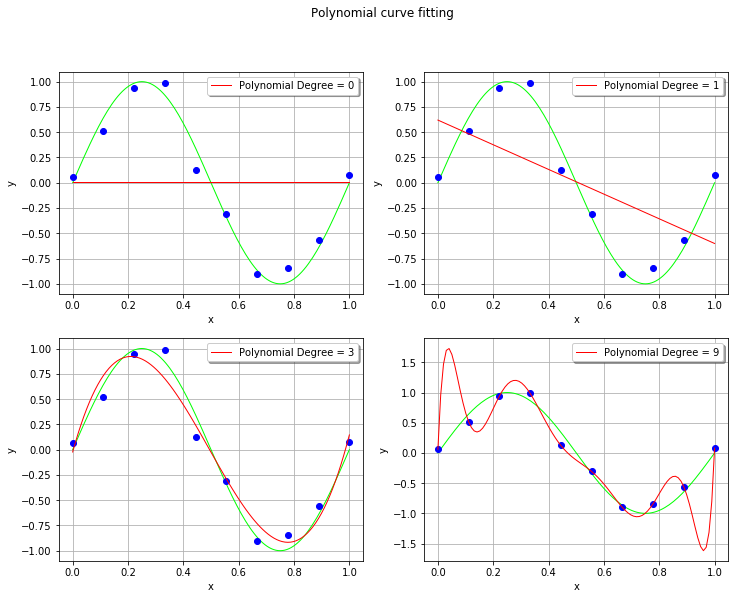

In [21]:
import pylab as pl
fig = pl.figure(figsize=(12, 9))
_ = fig.suptitle("Polynomial curve fitting")
ax_1 = fig.add_subplot(2, 2, 1)
_ = ot.viewer.View(myPolynomialCurveFittingGraph(0), figure=fig, axes=[ax_1])
ax_2 = fig.add_subplot(2, 2, 2)
_ = ot.viewer.View(myPolynomialCurveFittingGraph(1), figure=fig, axes=[ax_2])
ax_3 = fig.add_subplot(2, 2, 3)
_ = ot.viewer.View(myPolynomialCurveFittingGraph(3), figure=fig, axes=[ax_3])
ax_4 = fig.add_subplot(2, 2, 4)
_ = ot.viewer.View(myPolynomialCurveFittingGraph(9), figure=fig, axes=[ax_4])